In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Introduction

DSGE models (like our beloved RBC) require quarterly data. Sometimes you will find quarterly data, and life is wonderful. Sometimes you will instead find data at higher or lower frequences. 

This notebook will help you handle data that isn't at the right frequency.

# Case 1: High Frequency Data

Sometimes you can find data a frequency higher than quarterly, like monthly or weekly. This case isn't so bad. You just need to aggregate it to quarterly.

**The absolute most important thing here is that you set a DatetimeIndex! Use `parse_dates` when loading your data file!**

Let's look at the US Federal Funds rate, which is reported on a weekly basis.

In [2]:
# The symbol for the federal funds rate, FF, is nice and easy to remember.
# df = FredReader('FF', start='1900', end='2022').read()
# df.to_csv('fedfunds.csv')

df = pd.read_csv('fedfunds.csv', parse_dates=['DATE'], infer_datetime_format=True, index_col='DATE')
df.head()

,FF
DATE,
1954-07-07,1.00
1954-07-14,1.22
1954-07-21,0.57
1954-07-28,0.63
1954-08-04,0.27


When you have a `DatetimeIndex`, you can look at the frequency of the data by accessing the `index.inferred_freq` property. Here we can see it's Weekly data, repoted as Wednesday.

In [3]:
df.index.inferred_freq

'W-WED'

To aggregate to a higher frequency, we just use the `.resample` method. `resample` takes a string argument that tells the new frequency to go to. Common strings to use are:

- `YS` Annual data, using Jan 01 as the date.
- `Y`, Annual data, using Dec 31 as the date.
- `Y-OCT`, Annual data, using Oct 30 as the date (you can put any month after the dash)
- `QS`, Quarterly data, using the first day of the first month of each quarter as the date
- `Q`, Quarterly data, using the last day of the last month of each quarter as the date
- `Q-OCT`, Quarterly data, last day of the last month, starting from October (you can put any month after the dash)

Let's change our Federal Funds data to `QS`, quarterly and counting from the start of the quarter.

In [4]:
df.resample('QS')

As you can see, the result is a `DatetimeIndexReasampler` object. It has grouped all the weeks together into quarters, but it doesn't know what to do with them yet. Next, we need to pass an aggregation function. Options are:

1. `.sum()`. Add up everything inside each quarter to make quarterly data. This is appropriate for **FLOW** data.
2. `.last()`. Take only the last value and make it the quaterly value. That is, if we have 4 values (1, 2, 3, 4), we just use the 4. This is appropriate for **STOCK** data.
3. `.first()`. Take only the first value and make it the quarterly value. In the above example we use 1. Probably won't use this one much in time series.
3. `.mean()`. Take the mean of everything inside each quarter and use it as the quarterly value. This can be appropriate for **PRICE** data. Technically prices are stocks, but you might want to capture something about the volatility inside each period, which `.last()` doesn't do.
4. `.std()` and `.var()` to get a variance measurement. Not useful here.


Let's take the mean over each quarter and use that.

In [5]:
df_quarterly = df.resample('QS').mean()

As you can see, the quarterly matches up with the weekly data. We just lose some of the extreme values, beacuse we're talking a mean over the whole quarter. You could try experimenting with other aggregation functions (`min` and `max` are also options!) but this seems fine to me.

<AxesSubplot: xlabel='DATE'>

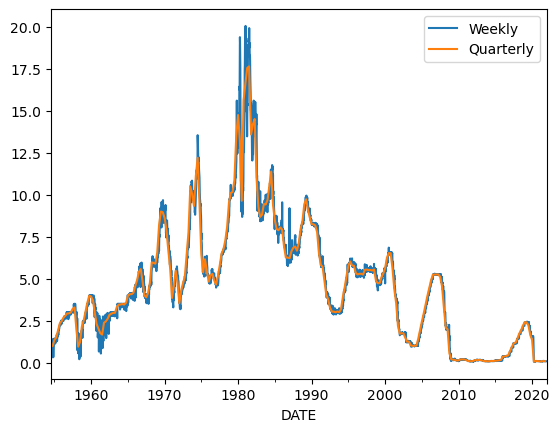

In [6]:
df.FF.plot(label='Weekly', legend=True)
df_quarterly.FF.plot(label='Quarterly', legend=True)

## Be careful about stock vs flow!

When aggregating, make sure you pay attention to stock vs flow data.

If we were aggregating flow data, it would **NOT** be appropriate to use `.mean()`! You must use `.sum()` in this case, because the quaterly value of the flows will be ALL the observations over the course of the quarter.

Similarly, it you were looking at stock data, it would also **NOT** be appropriate to use `.mean()`! In this case, you must use `.last()`, because the stock is slowly building each week throughout the quarter. The final stock for the whole quarter in that case is the value at the last week.

# Case 2: Low Frequency Data

Having low frequency data is by far the harder of the two cases. If you have annual data, it's not so easy to figure out how to break it into 4 quarterly pieces. 

As an example, let's look at annual consumption data.

In [7]:
# from pandas_datareader.fred import FredReader

# data = FredReader('PCECA', start='1900', end='2022-12-31').read()
# data.to_csv('annual_consumption.csv')

df = pd.read_csv('annual_consumption.csv', parse_dates=['DATE'], infer_datetime_format=True, index_col=['DATE'])
df.columns = ['C']

Looking at the frequency, we see we have annual data for the start of each January. 

In [8]:
df.index.inferred_freq

'AS-JAN'

In [9]:
df.head()

,C
DATE,
1929-01-01,77.382
1930-01-01,70.136
1931-01-01,60.672
1932-01-01,48.714
1933-01-01,45.945


<AxesSubplot: xlabel='DATE'>

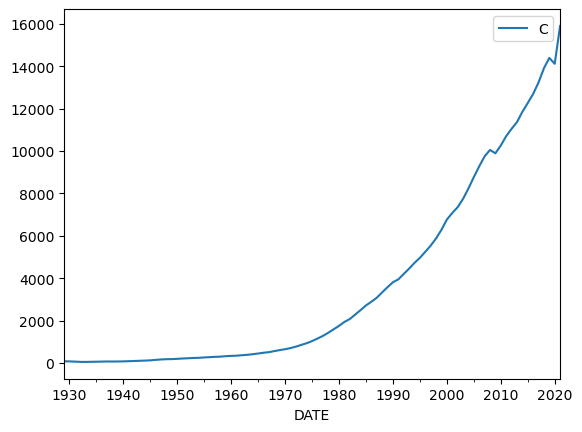

In [10]:
df.plot()

## Approach 1: Leave Missing Values

The first approach is to expand the index of the data to be quarterly, and leave 3 missing values each year. We can accomplish this with `.resample`. Since we don't want any aggregation function, we will use `.asfreq()`, which just says "convert this data to the new frequency without doing anything".

<AxesSubplot: xlabel='DATE'>

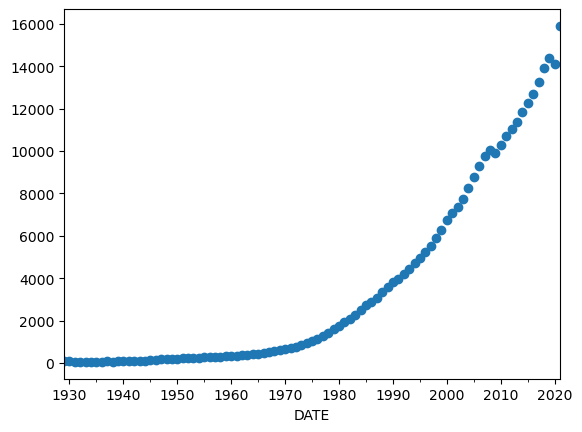

In [11]:
df.C.resample('QS').asfreq().plot(marker='o')

The problem with this approach is that it doesn't respect the fact that consumption is a flow variable. That is, if I asked you, "How many pizzas did you eat this year?", the number should be larger than if I asked you, "how many pizzas did you eat in the past 3 months?".

The number of pizzas you eat is a flow variable. We need to adjust the annual consumption down to reflect the fact that we're now considering quarterly values. The easiest way is to simply divide by 4. Dividing by 4 assumes that each quarter is more or less the same.

<AxesSubplot: xlabel='DATE'>

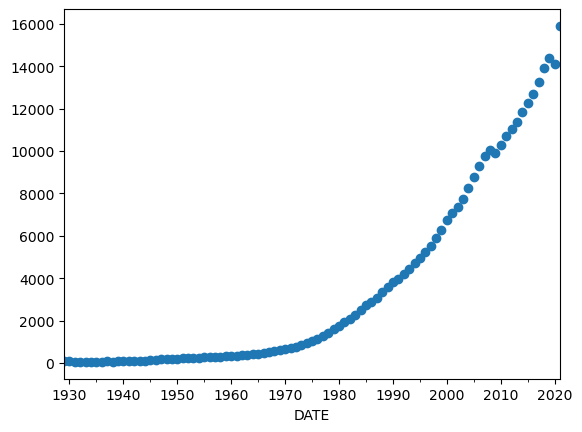

In [12]:
df.C.resample('QS').asfreq().plot(marker='o')

Now we have a series with a bunch of missing values. What can we do? Recall that the Kalman Filter can handle missing values, by replacing them with predictions from the model dynamcis. We can see how this looks by giving this data to a simple AR(1) model, estimated via Kalman Filter. `statsmodels.tsa.SARIMAX` does exacly this.

In [13]:
quarterly_C = df.C.mul(0.25).resample('QS').asfreq()
quarterly_C.tail()

DATE
2020-01-01    3529.04150
2020-04-01           NaN
2020-07-01           NaN
2020-10-01           NaN
2021-01-01    3975.64375
Freq: QS-JAN, Name: C, dtype: float64

One problem that I glossed over is that the last year ends up with only one quarter. We need to add the last 3 quarters ourselves.

In [14]:
quarterly_C = pd.concat([quarterly_C,
                         pd.Series(np.nan, 
                                   index=quarterly_C.index[-1] + np.array([1,2,3]) * quarterly_C.index.freq,
                                   name='C')])

In [15]:
quarterly_C.tail()

2020-10-01           NaN
2021-01-01    3975.64375
2021-04-01           NaN
2021-07-01           NaN
2021-10-01           NaN
Name: C, dtype: float64

In [16]:
import statsmodels.api as sm

# order is three numbers: (AR, Diff, MA). If this means nothing to you don't worry. But AR(1) corresponds to
# order (1, 0, 0).

# We set the trend to 'ctt' which means quadratic trend, since this data is increasing exponentially.
mod = sm.tsa.SARIMAX(quarterly_C, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)

/Users/jessegrabowski/opt/anaconda3/envs/econ/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/jessegrabowski/opt/anaconda3/envs/econ/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 1.295291
         Iterations: 535
         Function evaluations: 857


In [17]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      C   No. Observations:                  372
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -481.848
Date:                Sun, 04 Dec 2022   AIC                            973.697
Time:                        00:46:58   BIC                            993.291
Sample:                    01-01-1929   HQIC                           981.478
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3901      7.819      0.178      0.859     -13.936      16.716
drift         -0.1194      0.317     -0.377      0.706      -0.740       0.501
trend.2        0.0010      0.002      0.521      0.602      -0.003       0.005
ar.L1          0.9861      0.037     26.463      0.000       0.913       1.059
sigma2       471.3150     20.840     22.616      0.000     430.469     512.161
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            282519.82
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              44.36   Skew:                             4.94
Prob(H) (two-sided):                  0.00   Kurtosis:                       137.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As you can see, the Kalman Filter has filled in the gaps between the data points. The quality of the job it does will be related to the quality of our model. In this case, I don't imagine the model is very good!

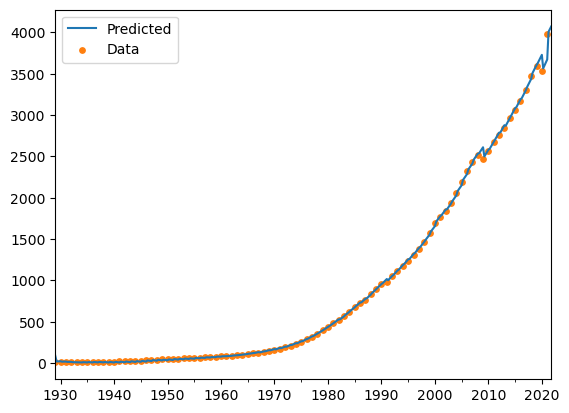

In [18]:
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax)
ax.scatter(quarterly_C.index, quarterly_C.values, s=15, color='tab:orange', label='Data')
ax.legend()
plt.show()

The series re-aggregates to something close to the original data, but it doesn't respect the adding up constraint that we would like. That is, ideally, the blue and the orange lines would be the same.

The advantage is that if we believe our model dynamics, this approach puts those dynamics into the missing values, even if the re-aggregation isn't 100% perfect. It's also quite easy to do.

<AxesSubplot: xlabel='DATE'>

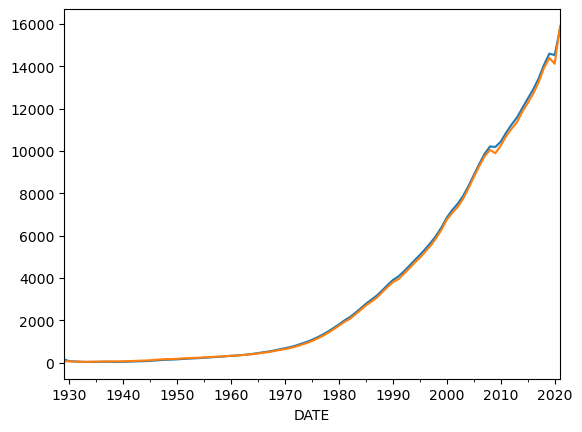

In [19]:
res.predict().resample('Y').sum().plot()
df.C.plot()

## Approach 2: Use `tsdisagg`

I wrote another python package called `tsdisagg` that includes models specifically for interpolating low frequeny data to high frequency. The result will always respect the adding up constraint.

First, we install the package using pip

In [20]:
!pip install tsdisagg

The main function to use is called `disaggregate_series`. It takes a low-frequency series (the annual consumption), and a target frequency. We want `QS`. We also tell it the aggregation function to respect. For flow data, we pick `sum`. We could also pick `first`, `last`, or `mean`, depending on the type of data we are working with.

In [21]:
from tsdisagg import disaggregate_series
quarterly_C = disaggregate_series(df, target_freq='QS', agg_func='sum')

The series that it produces are quite smooth (see the rounded tops and bottoms around 2015). 

<AxesSubplot: >

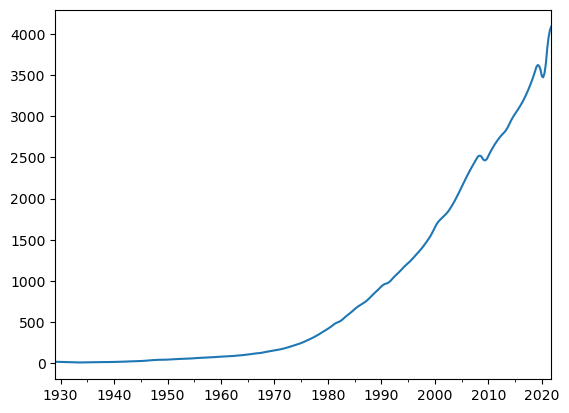

In [22]:
quarterly_C.plot()

As you can see, the adding up constraint is perfectly respected.

<AxesSubplot: xlabel='DATE'>

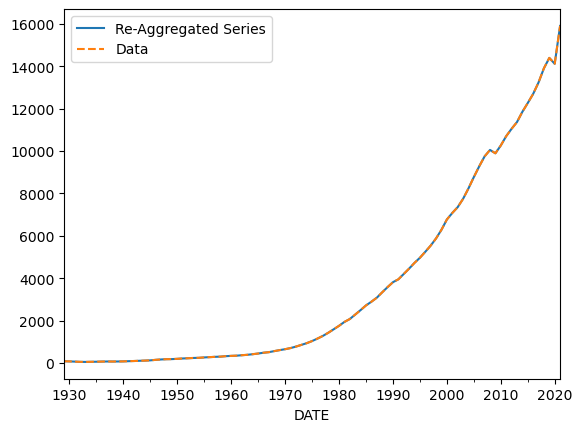

In [23]:
quarterly_C.resample('YS').sum().plot(label='Re-Aggregated Series', legend=True)
df.C.plot(ls='--', label='Data', legend=True)

There are several methods you can use in `tsdisagg`. Check the docstring of `disaggregate_series` for more information. The default method is called "denton-chalotte".

Another method implemented in `tsdisagg` is called "chow-lin". It is more powerful because you can supply correlated high frequency series to improve the quality of the interpolation. For example, suppose that we have quarterly GDP data, but only annual consumption data. We know that consumption and GDP are highly correlated. We can show the GDP data to `disaggregate_series` and use the "chow-lin" method to get a higher quality quarterly consumption series.

In [24]:
gdp = pd.read_csv('usa_gdp_seasonally_adjusted.csv', parse_dates=['DATE'], infer_datetime_format=True, index_col=['DATE'])

In [26]:
quarterly_C_cl = disaggregate_series(df.loc[gdp.index[0]:gdp.index[-1]], # The GDP only goes from 1960
                                     gdp.assign(Constant = 1), #Add a constant term to the regression
                                     method='chow-lin',
                                     agg_func='sum')

Dependent Variable: yearly_C
GLS Estimates using Chow-Lin's covariance matrix
N = 251		df = 247
Adj r2 = 0.9740

Variable             coef         sd err              t        P > |t|         [0.025         0.975]
----------------------------------------------------------------------------------------------------
NAEXKP01USQ652S    0.0000         0.0000        26.6594         0.0000         0.0000         0.0000
Constant        -644.7422      5289.0704        -0.1219         0.4515    -11062.1733      9772.6889

rho                1.0000
sigma.sq         279.9862


By adding the GDP series, a lot of little bumps and wiggles were passed along to the consumption series. We also get a larger dip during COVID than using the basic method.

In principle we can add as many indicator series as we like. Use your economic intuition to judge which series should be correlated with one another. We know from the IS-TR model that C = f(Y), so that's a good choice. We might also argue that I is a good choice, because Y = C + I. Maybe something like interest rates would be a less good choice.

As in all things Macroeconomic, you can do whatever you want, but then you have to convince other economists that it was the right thing to do!

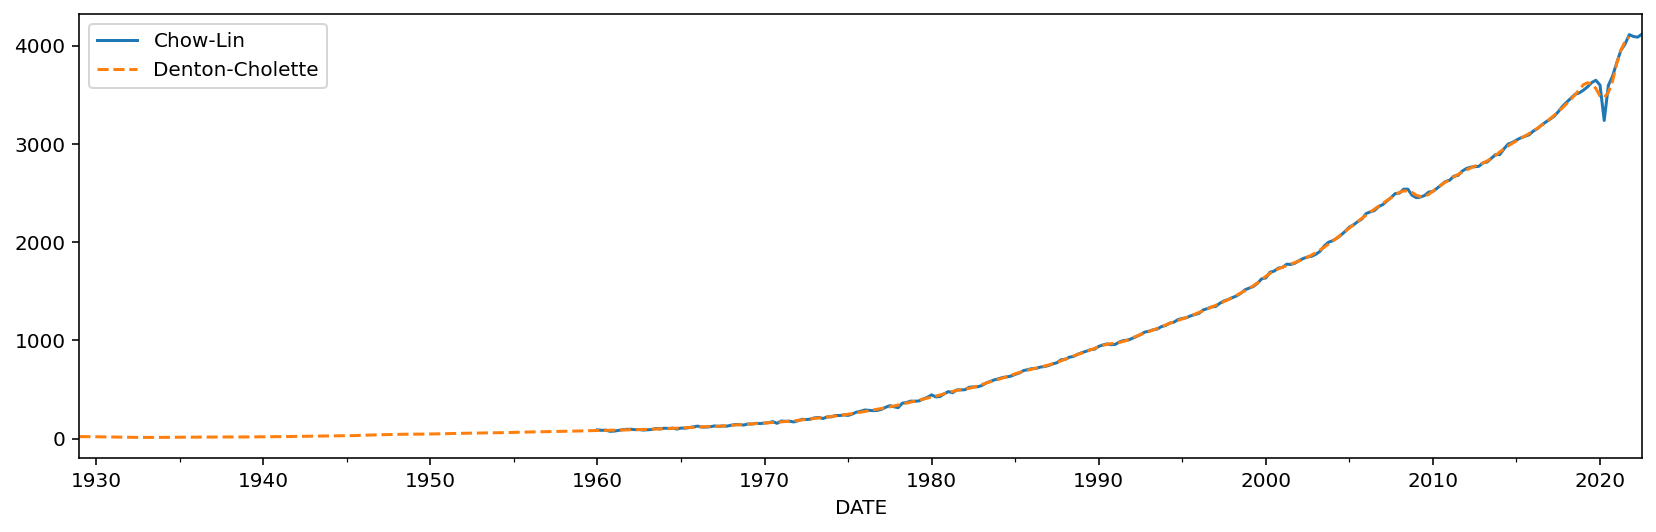

In [27]:
fig, ax = plt.subplots(figsize=(14,4), dpi=144)
quarterly_C_cl.plot(label='Chow-Lin', legend=True, ax=ax)
quarterly_C.plot(label='Denton-Cholette', legend=True, ls='--', ax=ax)
plt.show()

And, as you can see, the Chow-Lin estimated series still adds up to the original annual series (the dropoff at the end is because the GDP data I used didn't include all the quarters of 2022, so the sum is much less there).

<AxesSubplot: xlabel='DATE'>

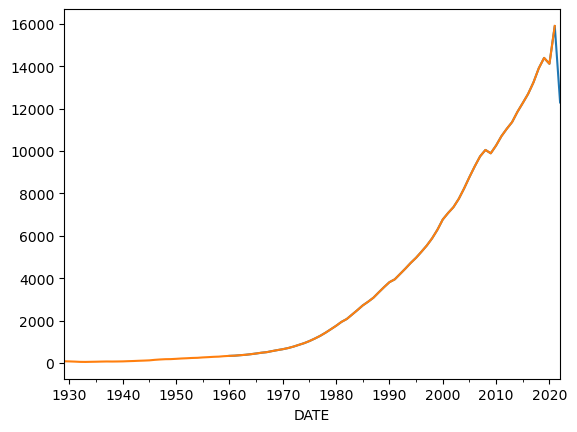

In [28]:
quarterly_C_cl.resample('YS').sum().plot()
df.C.plot()
